<a href="https://colab.research.google.com/github/iceman011/tutorials/blob/master/decision_tree_learning/basic_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()



X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)

gini_tree = DecisionTreeClassifier(random_state=0)
gini_tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gini_tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gini_tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


In [34]:
################ TREE PROPERTIES ###################

import numpy as np

n_nodes = gini_tree.tree_.node_count
children_left = gini_tree.tree_.children_left
children_right = gini_tree.tree_.children_right
feature = gini_tree.tree_.feature
threshold = gini_tree.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))



19.89
The binary tree structure has 35 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 20] <= 16.795000076293945 else to node 28.
	node=1 is a split node: go to node 2 if X[:, 27] <= 0.1359499990940094 else to node 17.
		node=2 is a split node: go to node 3 if X[:, 10] <= 1.047549992799759 else to node 16.
			node=3 is a split node: go to node 4 if X[:, 14] <= 0.003294000052846968 else to node 7.
				node=4 is a split node: go to node 5 if X[:, 1] <= 19.899999618530273 else to node 6.
					node=5 is a leaf node.
					node=6 is a leaf node.
				node=7 is a split node: go to node 8 if X[:, 13] <= 48.70000076293945 else to node 13.
					node=8 is a split node: go to node 9 if X[:, 21] <= 33.35000038146973 else to node 10.
						node=9 is a leaf node.
						node=10 is a split node: go to node 11 if X[:, 21] <= 33.79999923706055 else to node 12.
							node=11 is a leaf node.
							node=12 is a leaf node.
					node=13 is a split node: go to node 14

In [37]:
###### DECIOSION PATH ################
node_indicator = gini_tree.decision_path(X_test)
leaf_id = gini_tree.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample {id}:\n'.format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X_test[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))
    
##########################################33

sample_ids = [0, 2]
# boolean array indicating the nodes both samples go through
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))
# obtain node ids using position in array
common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples {samples} share the node(s) {nodes} in the "
      "tree.".format(samples=sample_ids, nodes=common_node_id))
print("This is {prop}% of all nodes.".format(
    prop=100 * len(common_node_id) / n_nodes))

Rules used to predict sample 0:

decision node 0 : (X_test[0, 20] = 14.45) <= 16.795000076293945)
decision node 1 : (X_test[0, 27] = 0.08045) <= 0.1359499990940094)
decision node 2 : (X_test[0, 10] = 0.3834) <= 1.047549992799759)
decision node 3 : (X_test[0, 14] = 0.007509) > 0.003294000052846968)
decision node 7 : (X_test[0, 13] = 28.62) <= 48.70000076293945)
decision node 8 : (X_test[0, 21] = 21.74) <= 33.35000038146973)

The following samples [0, 2] share the node(s) [0 1] in the tree.
This is 5.714285714285714% of all nodes.


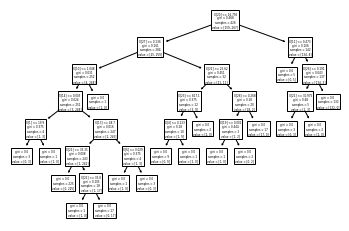

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import tree


"""**Pictorial representation of Decision Tree**"""

#plt.figure(figsize=(12,8))
tree.plot_tree(gini_tree)
plt.show()